In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from operator import add
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score
import random
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances




In [10]:
df =pd.read_csv('movies.csv')
df.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:

data= df.copy()
data = data[data['genres'] != "(no genres listed)"]
data.reset_index(drop=True, inplace=True)
data.head()

# Splitting genres if they are combined with "|"
unique_genres = set()
data['genres'].apply(lambda x: unique_genres.update(x.split('|')) if x != "(no genres listed)" else None)

print(f"Number of unique genres: {len(unique_genres)}")
genres = list(unique_genres)
print(genres)

Number of unique genres: 19
['Fantasy', 'Animation', 'Romance', 'Mystery', 'Adventure', 'Sci-Fi', 'Action', 'Thriller', 'Western', 'War', 'Documentary', 'Children', 'Film-Noir', 'Horror', 'Drama', 'Comedy', 'IMAX', 'Musical', 'Crime']


# Question 3

### Matrice C

In [12]:
# Remove the 'title' column from the DataFrame
data = data.drop(columns=['title'],axis=1)

# Create a binary column for each genre
for genre in genres:
    data[genre] = data['genres'].map(lambda x: int(genre in x.split("|")))

# Eliminate the original 'genres' column after processing
data = data.drop('genres', axis=1)

# Create a copy of the updated DataFrame
C_df = data.copy()

# Set 'movieId' as the index for the new DataFrame
C_df = C_df.set_index('movieId')

C_df


,Fantasy,Animation,Romance,Mystery,Adventure,Sci-Fi,Action,Thriller,Western,War,Documentary,Children,Film-Noir,Horror,Drama,Comedy,IMAX,Musical,Crime
movieId,,,,,,,,,,,,,,,,,,,
1,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0
2,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209155,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
209157,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
209159,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [13]:
# Count the occurrences of each genre by iterating through columns (excluding 'movieId') 
# and summing the binary values for each genre across all rows.

movies = {}
for column in C_df.columns:
    if column!='movieId':
        movies[column] = 0
        for i in C_df.index:
            movies[column] += C_df[column][i]


### Question 1

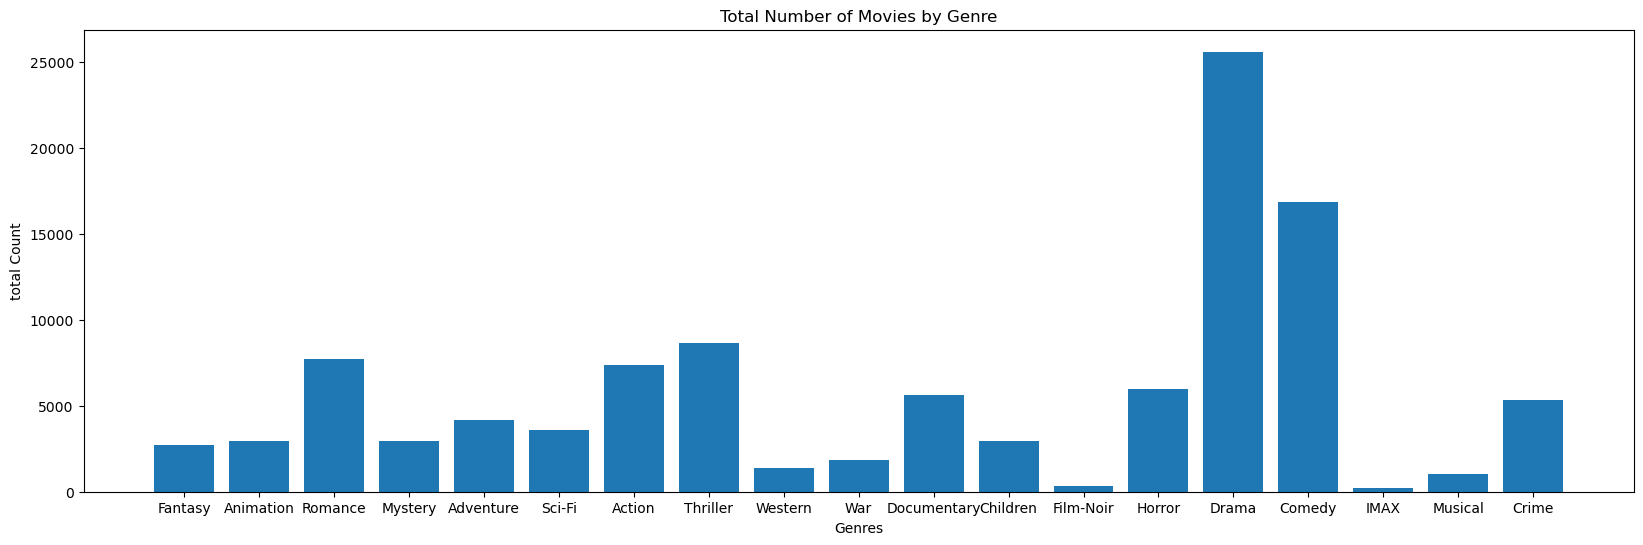

In [14]:
categories = list(movies.keys())
occurances = list(movies.values())

plt.figure(figsize=(20, 6))
plt.bar(categories, occurances)

plt.xlabel('Genres')
plt.ylabel('total Count')
plt.title('Total Number of Movies by Genre')

plt.show()

### Question 2

In [15]:
movies1= df.copy()
movies1 = movies1[movies1['genres'] != "(no genres listed)"]
movies1.to_csv("movies1.csv",index= False)
movies1.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


file reduction for easier manipulation 

In [16]:

threshold = 1000

data_2= pd.read_csv("ratings.csv")
rating1 = data_2.copy()

# Count the number of ratings per user
user_rating_counts = rating1.groupby('userId').size()

# Filter out users with fewer ratings than the threshold
filtered_users = user_rating_counts[user_rating_counts >= threshold].index

# Reduce the DataFrame by keeping only the filtered users
filtered_data_rt = rating1[rating1['userId'].isin(filtered_users)]

# Save the reduced DataFrame to a new file for later use
#filtered_data_rt.to_csv('reduced_file.csv', index=False)

# Display the size reduction
original_size = rating1.shape[0]
reduced_size = filtered_data_rt.shape[0]
reduction_percentage = 100 * (original_size - reduced_size) / original_size

print(f"Original number of rows: {original_size}")
print(f"Reduced number of rows: {reduced_size}")
print(f"Reduction percentage: {reduction_percentage:.2f}%")
 
rating1 = filtered_data_rt


Original number of rows: 25000095
Reduced number of rows: 4192357
Reduction percentage: 83.23%


In [17]:
rating1 = rating1[rating1['movieId'].isin(data['movieId'])]
rating1['rating'] =np.floor(rating1['rating']).astype(int)
rating1['rating'] = rating1['rating'].replace(0, 1)
rating1.to_csv("ratings1.csv", index = False)

/var/folders/kt/8_37cyfj203cgl7zt0_w680r0000gn/T/ipykernel_93023/4136547044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating1['rating'] =np.floor(rating1['rating']).astype(int)
/var/folders/kt/8_37cyfj203cgl7zt0_w680r0000gn/T/ipykernel_93023/4136547044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating1['rating'] = rating1['rating'].replace(0, 1)


In [18]:
rating1.head(5)

,userId,movieId,rating,timestamp
23893,187,1,3,1277374478
23894,187,2,3,1277374864
23895,187,3,3,1277839361
23896,187,13,4,1277374351
23897,187,19,4,1277373060


Question 4

In [19]:
# Merge the rating1 and C_df DataFrames on 'movieId' using a left join
merged_data = pd.merge(rating1, C_df, on='movieId', how='left')

# Create a weighted user profile matrix by multiplying ratings with genre columns
ratings_vector = merged_data['rating'].values[:, np.newaxis]
genre_matrix = merged_data.iloc[:, 4:]
user_profile_matrix = ratings_vector * genre_matrix

# Summarize the weighted preferences for each user by grouping by 'userId'
user_profile_matrix = pd.DataFrame(user_profile_matrix).groupby(merged_data['userId']).sum()

# Reset the index for the resulting user profile DataFrame
user_profile_matrix.reset_index(inplace=True)

# Save the user profile data to a CSV file
#user_profile_matrix.to_csv('user_profile.csv', index=False)

# Display the first 10 rows of the user profile matrix
user_profile_matrix.head(5)


,userId,Fantasy,Animation,Romance,Mystery,Adventure,Sci-Fi,Action,Thriller,Western,War,Documentary,Children,Film-Noir,Horror,Drama,Comedy,IMAX,Musical,Crime
0,187,682,377,508,466,1056,1001,1507,1825,37,126,132,444,14,873,1742,2032,336,98,732
1,426,133,52,338,254,357,261,669,854,71,214,126,82,32,182,1770,631,82,69,616
2,541,595,912,706,345,1112,524,1049,747,99,403,89,708,49,107,2238,1204,251,123,614
3,548,854,181,1313,935,1400,1273,3168,3751,115,356,6,390,49,1653,4101,3319,320,106,1950
4,626,652,326,1311,354,1301,844,1258,973,228,361,64,763,30,346,2648,2416,67,525,550


### Question 5

In [20]:
# Load the ratings1.csv file
ratings_data = pd.read_csv("ratings1.csv")

# Split the data into training (80%) and evaluation (20%) sets
ratings_apprendissage, ratings_evaluation = train_test_split(ratings_data, test_size=0.2, random_state=42)

# Save the training set to ratings_apprentissage.csv
ratings_apprendissage.to_csv("ratings_apprentissage.csv", index=False)

# Save the evaluation set to ratings_evaluation.csv
ratings_evaluation.to_csv("ratings_evaluation.csv", index=False)

# Print the sizes of the datasets
print(f"Training set size: {ratings_apprendissage.shape[0]} rows")
print(f"Evaluation set size: {ratings_evaluation.shape[0]} rows")


Training set size: 3343508 rows
Evaluation set size: 835877 rows


### Question 6

Pearson correlation function

In [21]:
user_item_matrix = user_profile_matrix
user_item_matrix = user_item_matrix.set_index('userId')


# Function to calculate Pearson correlation similarity between two users
def pearson_similarity(user1, user2):
    common_items = user_item_matrix.loc[user1].notna() & user_item_matrix.loc[user2].notna()
    if common_items.sum() == 0:  # No common items
        return 0

    user1_ratings = user_item_matrix.loc[user1, common_items]
    user2_ratings = user_item_matrix.loc[user2, common_items]

    user1_mean = user1_ratings.mean()
    user2_mean = user2_ratings.mean()

    numerator = np.sum((user1_ratings - user1_mean) * (user2_ratings - user2_mean))
    denominator = np.sqrt(np.sum((user1_ratings - user1_mean) ** 2)) * np.sqrt(np.sum((user2_ratings - user2_mean) ** 2))

    return numerator / denominator if denominator != 0 else 0


In [22]:

# Function to estimate a user's rating for a specific item
def estimate_rating(user_id, item_id, k=5):
    if item_id not in user_item_matrix.columns or user_id not in user_item_matrix.index:
        return user_item_matrix.mean(axis=1).mean()  # Global average if unknown

    users_who_rated_item = user_item_matrix[item_id].dropna().index
    similarities = [(other_user, pearson_similarity(user_id, other_user)) for other_user in users_who_rated_item]
    similarities = sorted(similarities, key=lambda x: x[1], reverse=True)[:k]

    numerator = 0
    denominator = 0
    for other_user, similarity in similarities:
        rating = user_item_matrix.at[other_user, item_id]
        numerator += similarity * (rating - user_item_matrix.loc[other_user].mean())
        denominator += abs(similarity)

    user_mean = user_item_matrix.loc[user_id].mean()
    predicted_rating = user_mean + (numerator / denominator if denominator != 0 else 0)

    # Clip the rating to the range [1, 5]
    return max(1, min(5, predicted_rating))


In [23]:
def predict_ratings(eval_data, k=5):
    predictions = []
    for _, row in eval_data.iterrows():  # Process all rows in eval_data
        user_id = row['userId']
        item_id = row['movieId']
        predictions.append(estimate_rating(user_id, item_id, k))
    return predictions

# Predict ratings for the entire evaluation set
ratings_evaluation['predicted_rating'] = predict_ratings(ratings_evaluation, k=2)

# Calculate Mean Absolute Error (MAE) for the full dataset
mae = np.mean(abs(ratings_evaluation['rating'] - ratings_evaluation['predicted_rating']))

print(f"Mean Absolute Error (MAE): {mae:.4f}")

# Save predictions to a CSV file
#ratings_evaluation.to_csv("ratings_predictions.csv", index=False)


Mean Absolute Error (MAE): 633.9297


Prediction Function

In [24]:
ratings_evaluation.head(5)

,userId,movieId,rating,timestamp,predicted_rating
1811044,72211,7958,3,1524414519,636.996576
3319252,129769,1249,3,1358442925,636.996576
1279076,49619,2950,3,966789027,636.996576
2394995,92435,80846,4,1540354282,636.996576
2823550,109731,1164,1,1548012190,636.996576


### Question 7

In [25]:
users = [random.randint(1, 162541) for _ in range(2675)] #2675 because that is the number of rows in the user_profile_matrix
X = user_item_matrix.sample(n=2000, random_state=42)
X.head(5)

,Fantasy,Animation,Romance,Mystery,Adventure,Sci-Fi,Action,Thriller,Western,War,Documentary,Children,Film-Noir,Horror,Drama,Comedy,IMAX,Musical,Crime
userId,,,,,,,,,,,,,,,,,,,
51278,662,49,444,370,1080,1170,1979,1772,41,92,4,127,9,787,1363,823,415,14,641
146475,688,562,444,275,1532,1003,1757,1155,58,155,66,552,13,449,1369,1326,388,86,564
28826,477,289,588,411,760,685,1026,1253,35,95,96,312,36,583,1801,1269,214,157,675
35891,313,149,1147,451,607,406,729,1100,146,316,70,212,119,364,2747,1374,28,224,682
110164,407,145,1186,637,994,703,1636,1774,139,567,207,229,111,504,3349,2205,86,178,1233


Pour k=2, le silhouette score est : 0.34


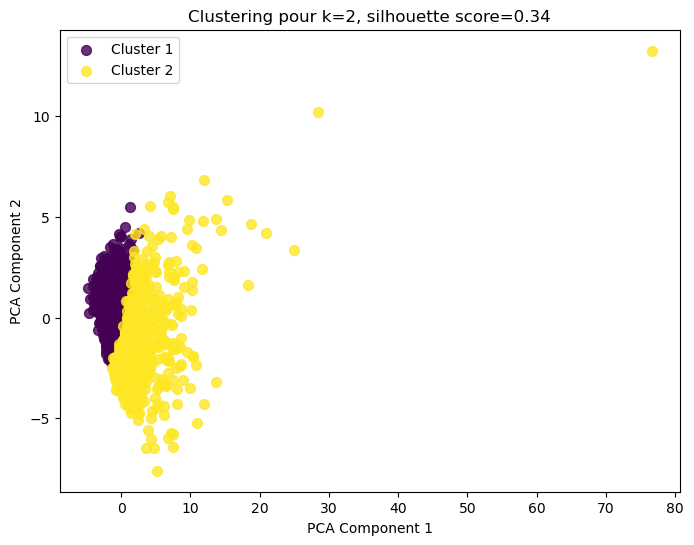

Pour k=3, le silhouette score est : 0.19


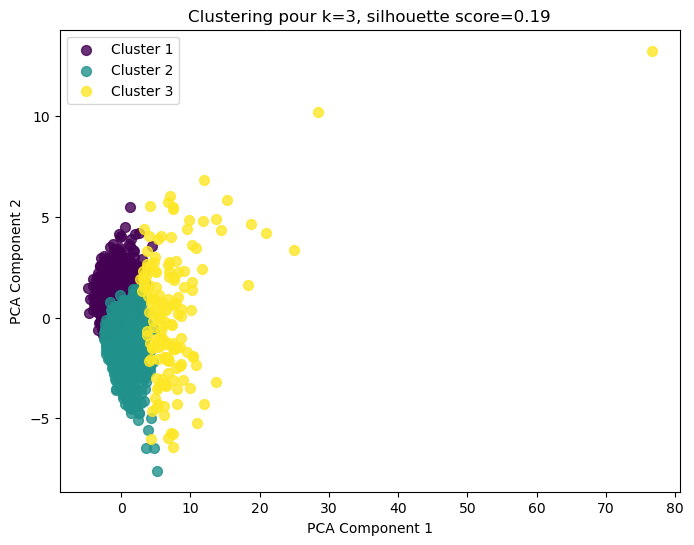

Pour k=4, le silhouette score est : 0.14


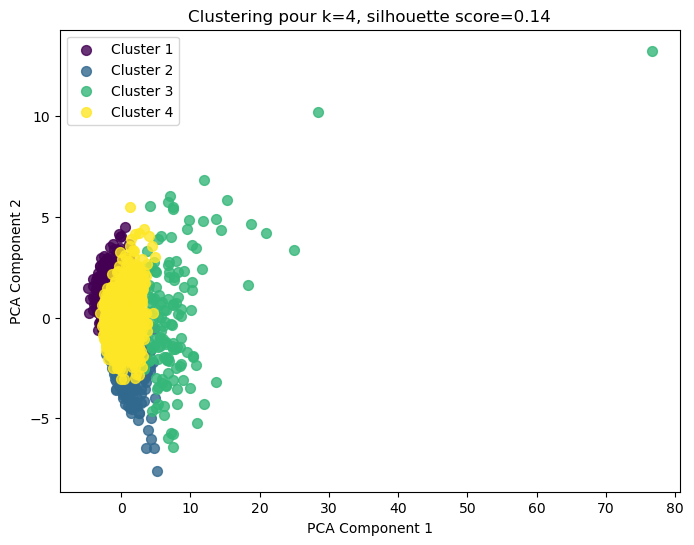

Pour k=5, le silhouette score est : 0.13


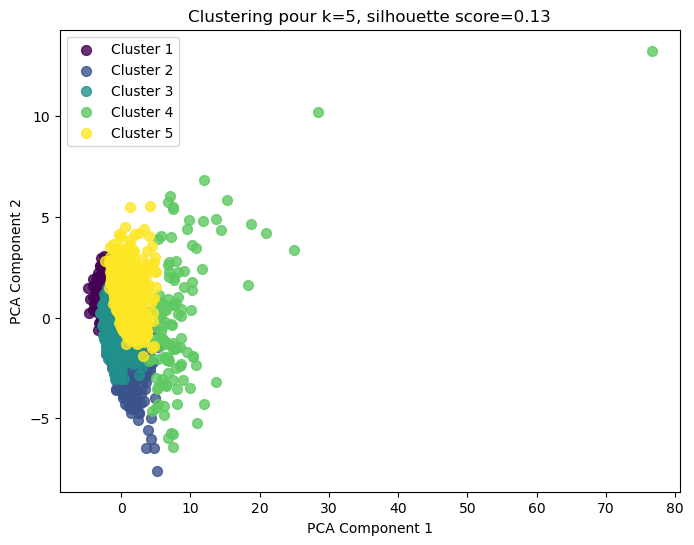

Pour k=6, le silhouette score est : 0.12


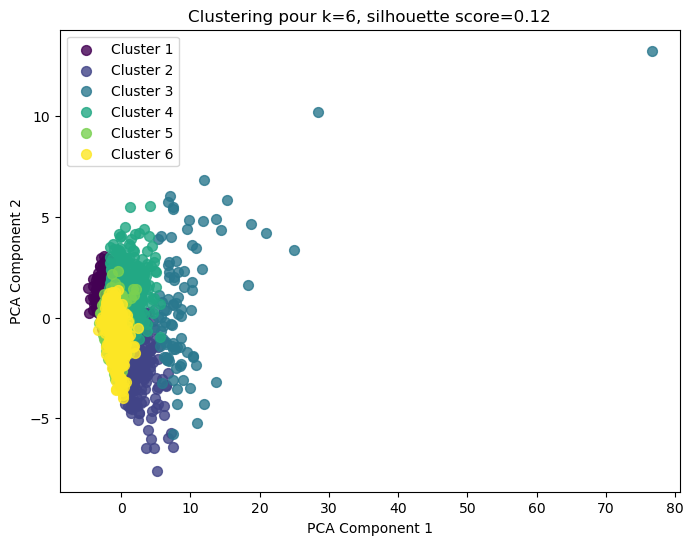

Silhouette scores for all k values: {2: 0.3358066284598939, 3: 0.19344133435805297, 4: 0.14190351099084797, 5: 0.12805031823560012, 6: 0.11557379287342151}


In [26]:
# Apply PCA to reduce dimensionality
def apply_pca(X, n_components=2):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    return X_scaled, X_pca

# Perform clustering and calculate silhouette scores
def perform_clustering(X_scaled, X_pca, k_values, n_neighbors=10):
    silhouette_scores = {}

    for k in k_values:
        # Create SpectralClustering model
        clustering = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors', n_neighbors=n_neighbors)
        labels = clustering.fit_predict(X_scaled)

        # Compute silhouette score
        silhouette_avg = silhouette_score(X_scaled, labels)
        silhouette_scores[k] = silhouette_avg
        print(f"Pour k={k}, le silhouette score est : {silhouette_avg:.2f}")

        # Plot clusters
        visualize_clusters(X_pca, labels, k, silhouette_avg)

    return silhouette_scores

# Visualize clusters
def visualize_clusters(X_pca, labels, k, silhouette_avg):
    colors = plt.cm.viridis(np.linspace(0, 1, k))  # Generate distinct colors for clusters

    plt.figure(figsize=(8, 6))
    for cluster_id in range(k):
        cluster_points = X_pca[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colors[cluster_id]], s=50, alpha=0.8, label=f'Cluster {cluster_id + 1}')
    
    plt.title(f'Clustering pour k={k}, silhouette score={silhouette_avg:.2f}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

# Main code
X_scaled, X_pca = apply_pca(X)  
k_values = range(2, 7)  # Range of k to evaluate
silhouette_scores = perform_clustering(X_scaled, X_pca, k_values)

# Display silhouette scores summary
print("Silhouette scores for all k values:", silhouette_scores)


- Étant donné que les nuages de points ne sont pas clairs, nous utiliserons le T-SNE.

Pour k=2, le silhouette score est : 0.31


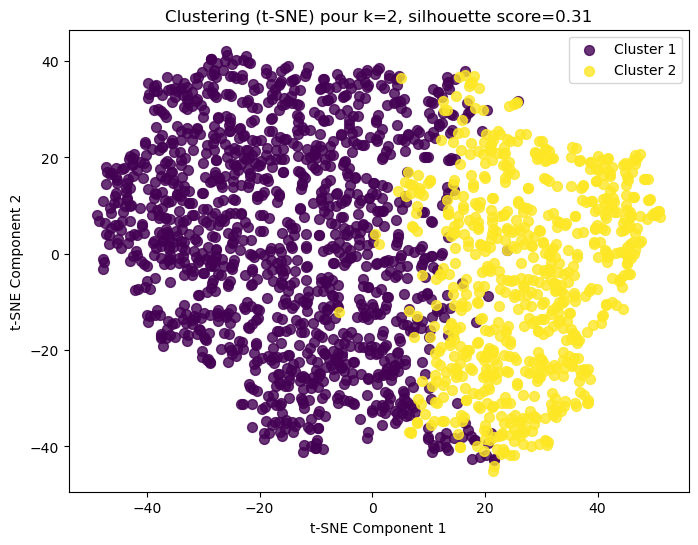

Pour k=3, le silhouette score est : 0.19


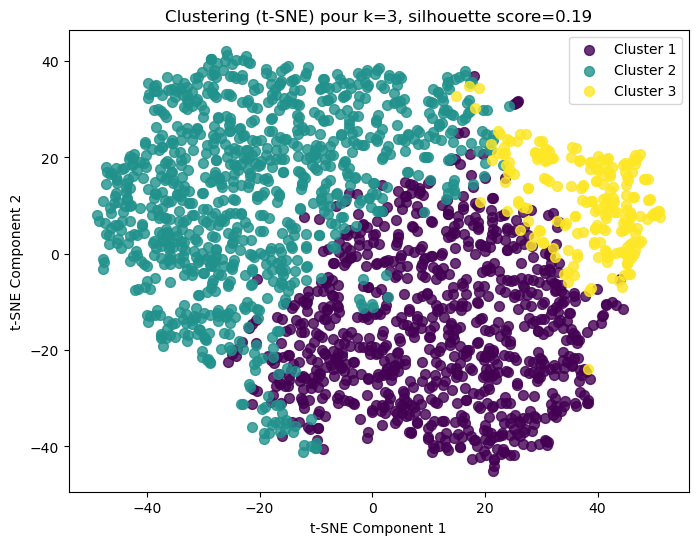

Pour k=4, le silhouette score est : 0.14


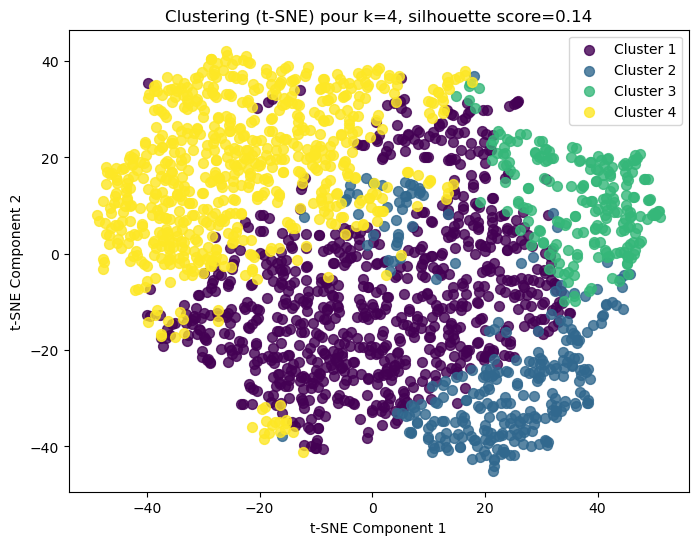

Pour k=5, le silhouette score est : 0.12


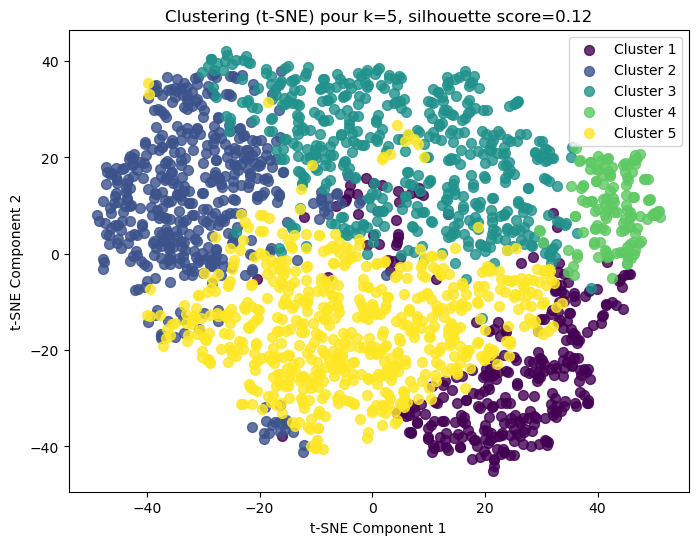

Pour k=6, le silhouette score est : 0.11


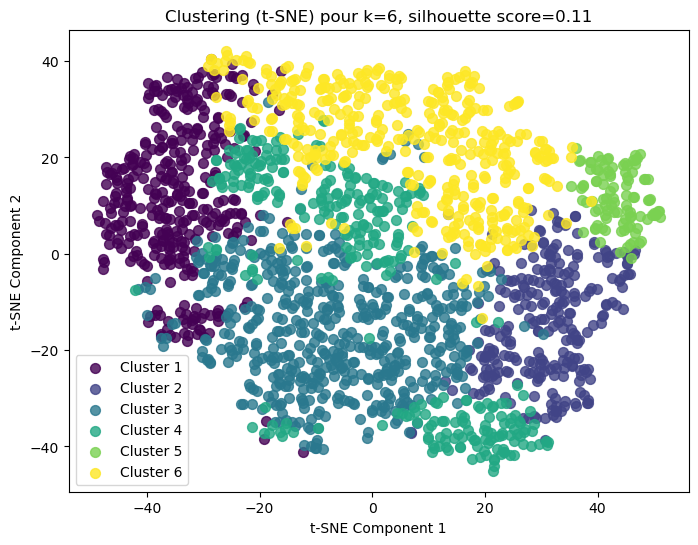

Silhouette scores for all k values: {2: 0.30725436392823907, 3: 0.18951334990629318, 4: 0.14000943813486755, 5: 0.11673965977326198, 6: 0.10684127637650875}


In [27]:
# Apply t-SNE to reduce dimensionality
def apply_tsne(X, n_components=2, random_state=42):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    tsne = TSNE(n_components=n_components, random_state=random_state)
    X_tsne = tsne.fit_transform(X_scaled)
    return X_scaled, X_tsne

# Perform clustering and calculate silhouette scores
def perform_clustering_with_tsne(X_scaled, X_tsne, k_values, n_neighbors=15):
    silhouette_scores = {}

    for k in k_values:
        # Create SpectralClustering model
        clustering = SpectralClustering(n_clusters=k, random_state=42, affinity='nearest_neighbors', n_neighbors=n_neighbors)
        labels = clustering.fit_predict(X_scaled)

        # Compute silhouette score
        silhouette_avg = silhouette_score(X_scaled, labels)
        silhouette_scores[k] = silhouette_avg
        print(f"Pour k={k}, le silhouette score est : {silhouette_avg:.2f}")

        # Plot clusters
        visualize_tsne_clusters(X_tsne, labels, k, silhouette_avg)

    return silhouette_scores

# Visualize clusters with t-SNE
def visualize_tsne_clusters(X_tsne, labels, k, silhouette_avg):
    colors = plt.cm.viridis(np.linspace(0, 1, k))  # Generate distinct colors for clusters

    plt.figure(figsize=(8, 6))
    for cluster_id in range(k):
        cluster_points = X_tsne[labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colors[cluster_id]], s=50, alpha=0.8, label=f'Cluster {cluster_id + 1}')
    
    plt.title(f'Clustering (t-SNE) pour k={k}, silhouette score={silhouette_avg:.2f}')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()
    plt.show()

# Main code
X_scaled, X_tsne = apply_tsne(X)  # Replace `X` with your dataset
k_values = range(2, 7)  # Range of k to evaluate
silhouette_scores = perform_clustering_with_tsne(X_scaled, X_tsne, k_values)

# Display silhouette scores summary
print("Silhouette scores for all k values:", silhouette_scores)

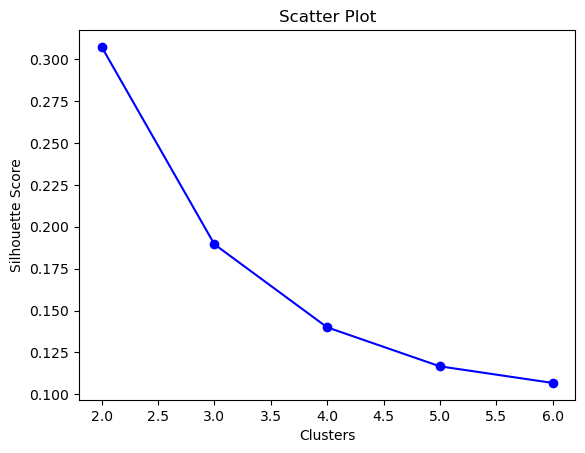

In [28]:
x_values = list(silhouette_scores.keys())
y_values = list(silhouette_scores.values())

plt.plot(x_values, y_values,  marker='o', linestyle='-', color='blue')

plt.title('Scatter Plot')
plt.xlabel('Clusters')
plt.ylabel('Silhouette Score')

plt.show()

We assign the other users to the generated clusters.

In [29]:
clustering = SpectralClustering(n_clusters=4, random_state=42, affinity='nearest_neighbors', n_neighbors=15).fit(X)
    # clusters prediction
labels = clustering.labels_


In [30]:
centroids = np.zeros((len(set(labels)), user_profile_matrix.iloc[:, 1:].shape[1]))
for cluster in set(clustering.labels_):
    centroids[cluster] = X[labels== cluster].mean(axis=0)
print(centroids)

[[ 316.90625     169.40401786  856.37053571  328.32366071  564.73214286
   376.02232143  676.31919643  876.19642857   85.14285714  216.02678571
   124.50669643  244.06473214   72.13169643  234.90848214 2326.15625
  1481.11383929   64.81919643  180.27678571  632.81026786]
 [ 402.67053364  236.81090487  528.48491879  290.46287703  770.13225058
   605.94663573 1076.33294664 1008.81438515   68.80974478  154.07888631
    61.49071926  288.59396752   31.19721578  370.56728538 1443.7262181
  1273.64617169  138.10672854  119.67981439  584.61716937]
 [ 867.73636364  480.00909091 2072.52727273  929.46363636 1526.30909091
  1181.41818182 2231.46363636 2878.00909091  291.75454545  574.98181818
   476.92727273  598.4         202.39090909 1208.91818182 6347.41818182
  3903.55454545  231.99090909  423.96363636 1781.19090909]
 [ 565.11551724  334.17758621  947.7137931   463.41034483 1078.83103448
   840.92931034 1513.66206897 1542.55862069  127.06724138  278.29655172
   149.5137931   410.60172414   68.

In [ ]:

remaining_users_indices = np.array(user_profile_matrix['userId'][~user_profile_matrix['userId'].isin(X.index)])
remaining_users_df = user_profile_matrix[user_profile_matrix['userId'].isin(remaining_users_indices)]

distances = euclidean_distances(remaining_users_df.iloc[:,1:], centroids)
assigned_clusters_remaining_users = np.argmin(distances, axis=1)

user_profile_matrix['cluster'] = np.nan
user_profile_matrix.loc[remaining_users_df.index, 'cluster'] = assigned_clusters_remaining_users
user_profile_matrix.loc[X.index, 'cluster'] = labels


In [32]:
user_profile_matrix['cluster'].value_counts()

cluster
1.0    324
0.0    164
3.0    154
2.0     33
Name: count, dtype: int64

In [33]:
print(user_profile_matrix)

      userId  Fantasy  Animation  Romance  Mystery  Adventure  Sci-Fi  Action  \
0        187      682        377      508      466       1056    1001    1507   
1        426      133         52      338      254        357     261     669   
2        541      595        912      706      345       1112     524    1049   
3        548      854        181     1313      935       1400    1273    3168   
4        626      652        326     1311      354       1301     844    1258   
...      ...      ...        ...      ...      ...        ...     ...     ...   
2670  162047      711        664     2126     1759       1159    1047    2051   
2671  162271      433        278     1474      465        696     641     847   
2672  162495      476        226      405      239        961     637    1441   
2673  162508      256        135      765      330        543     237     705   
2674  162516     1020        770     1927     1017       1972    1684    2586   

      Thriller  Western  ..